<h1> Processing Brazil's Climate Data: Aggregating INMET Data from Brazilian State Capitals </h1>

INMET offers many data systems with weather data measurements from across Brazil. However, differently from DATASUS (https://medium.com/@victorfoscarini/unlocking-brazils-mortality-data-a-guide-to-extracting-sim-datasus-data-with-the-microdatasus-d7ea7bb1cc61), it is not very homogeneous and requires a thorough analysis and data preprocessing to ensure its validity before using it. The best data source for a large-scale study is INMET's automatic stations (https://portal.inmet.gov.br/dadoshistoricos). They have historical data available since 2000 for cities across the countries, but it varies widely from city to city. For example, in 2000, only five stations were available, but more were available in the latter years.

For our study, we decided to focus on the state capitals because they generally have more quality data, fewer missing values, and are available for more years. At the moment of extraction, we had data available from 2000 to 2019. Still, we decided to narrow it down to the interval of 2013 to 2018 since, on that interval, we have data available for all state capitals of the country.

Note: I'm using an integrated Colab + Google Drive environment for this project, but this could be done similarly with a local Jupyter lab, Jupyter notebook, or even just a regular Python compiler.

# Importing Libraries and Defining States, Capitals, Stations and Weather Variables


In [ ]:
!pip install numpy==1.23.5
!pip install pandas==2.1.1
!pip install xlrd==2.0.1
!pip install matplotlib==3.7.1
!pip install seaborn==0.13.0
!pip install ipython==7.34.0
!pip install epiweeks==2.2.0
!pip install regex==2023.6.3
!pip install scipy==1.11.4
!pip install sklearn==1.2.2

In [ ]:
#importing libraries

#ds libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
import os

#processing
import missingno as msno
from sklearn.impute import KNNImputer

#print
BOLD = '\033[1m'
END = '\033[0m'

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/seasonal_mortality_hub/data/'

In [ ]:
#states and capitals

states = ['RS', 'SC', 'PR', 'SP', 'RJ', 'MS', 'ES', 'MG', 'GO', 'DF', 'MT', 'BA',
          'SE', 'TO', 'AC', 'AL', 'RO', 'PE', 'PB', 'RN', 'PI', 'CE', 'AM', 'MA', 'PA', 'AP', 'RR']
capital_dict = {
 'RS': 'Porto Alegre - RS',
 'SC': 'Florianópolis - SC',
 'PR': 'Curitiba - PR',
 'SP': 'São Paulo - SP',
 'RJ': 'Rio de Janeiro - RJ',
 'MS': 'Campo Grande - MS',
 'ES': 'Vitória - ES',
 'MG': 'Belo Horizonte - MG',
 'GO': 'Goiânia - GO',
 'DF': 'Brasília - DF',
 'MT': 'Cuiabá - MT',
 'BA': 'Salvador - BA',
 'SE': 'Aracaju - SE',
 'TO': 'Palmas - TO',
 'AC': 'Rio Branco - AC',
 'AL': 'Maceió - AL',
 'RO': 'Porto Velho - RO',
 'PE': 'Recife - PE',
 'PB': 'João Pessoa - PB',
 'RN': 'Natal - RN',
 'PI': 'Teresina - PI',
 'CE': 'Fortaleza - CE',
 'AM': 'Manaus - AM',
 'MA': 'São Luís - MA',
 'PA': 'Belém - PA',
 'AP': 'Macapá - AP',
 'RR': 'Boa Vista - RR'
}

# stations catalogue - file names by capital
# state : capital_code #city - year_operation_start - Nth_city_inside_state_to_start_operation
station_dict = {
    'RS': 'A801', #porto alegre - 2000 - 1
    'SC': 'A806', #florianopolis - 2003 - 1
    'PR': 'A807', #curitiba - 2003 - 1
    'SP': 'A701', #sao paulo - 2006 - 7
    'RJ': 'A603', #rio de janeiro - 2002 - 2
    'MS': 'A702', #campo grande - 2001 - 3
    'ES': 'A612', #vitoria - 2006 - 4
    'MG': 'A521', #belo horizonte - 2006 - 23
    'GO': 'A002', #goiania - 2001 - 2
    'DF': 'A001', #brasilia - 2000 - 1
    'MT': 'A901', #cuiaba - 2002 - 1
    'BA': 'A401', #salvador - 2000 - 1
    'SE': 'A409', #aracaju - 2003 - 1
    'TO': 'A009', #palmas - 2004 - 1
    'AC': 'A104', #rio branco - 2008 - 1
    'AL': 'A303', #maceio - 2003 - 1
    'RO': 'A925', #porto velho - 2007 - 1
    'PE': 'A301', #recife - 2004 - 3
    'PB': 'A320', #joao pessoa - 2007 - 3
    'RN': 'A304', #natal - 2003 - 1
    'PI': 'A312', #teresina - 2004 - 3
    'CE': 'A305', #fortaleza - 2003 - 2
    'AM': 'A101', #manaus - 2000 - 1
    'MA': 'A203', #sao luis - 2003 - 1
    'PA': 'A201', #belem - 2003 - 1
    'AP': 'A249', #macapa - 2013 - 3
    'RR': 'A135', #boa vista - 2010 - 1
    }

# weather variables dictionary
weather_dict = {
    'DATA (YYYY-MM-DD)': 'date',
    'HORA (UTC)': 'hour',
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitation',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'atmospheric_pressure',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'max_atmospheric_pressure',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min_atmospheric_pressure',
    'RADIACAO GLOBAL (KJ/m²)': 'global_radiation',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'air_temperature',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'dew_point_temperature',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max_air_temperature',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min_air_temperature',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'max_dew_point_temperature',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'min_dew_point_temperature',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'max_relative_humidity',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min_relative_humidity',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'relative_humidity',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wind_direction',
    'VENTO, RAJADA MAXIMA (m/s)': 'max_wind_gust',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'wind_speed'
}

# Processing data

Macapá sets the date range to 2013-2018, as it is the state capital with less data available. In that 6-year range, there's data for all state capitals. Outside that interval, it varies a lot. In general, the more recent years have less missing data, but there are exceptions and capitals in which the contrary is valid.

### Grouping data

I grouped the data into time series with hourly measurements, by state capital, year, and weather variables. After evaluating the data spanning all available years that differ for each city versus restricting it to 2013 to 2018, I opted to use only the data from 2013 to 2018 for all cities, although some had a larger interval of quality data. I did that to avoid biases from comparing cities with data from different years. The chosen interval has sufficient data, so limiting the range does not substantially increase missing data for the following process: aggregating the data into a single-year time series.

I averaged each city's time series over a single year and compared it with the non-aggregated data. Transforming the data into a single-year aggregated time series helped reduce missing data and simplifies our future analysis since we are interested in investigating the yearly pattern.

In [ ]:
# Grouping years separately
first_year, last_year = 2000, 2019

df = None
missing_data = None
for state, station in zip(list(station_dict.keys()), list(station_dict.values())):
  # find file from station
  r = re.compile(f'.+{station}.+')

  for year in np.arange(first_year, last_year+1):
    try:

      # Get the data and basic processing
      file_name = list(filter(r.search, os.listdir(f'{path}inmet/{year}/')))[0]
      data = pd.read_csv(f'{path}inmet/{year}/{file_name}', skiprows=8,
                        encoding='latin-1', sep=';', on_bad_lines='warn', dtype='object')
      data = data.replace('-9999', np.nan)
      data = data.drop(columns=['Unnamed: 19'])
      data = data.rename(columns={'Data': 'DATA (YYYY-MM-DD)',
                                  'Hora UTC': 'HORA (UTC)'})
      data = data.rename(columns=weather_dict)

      # Get the time from date and hour, remove year as well
      # Set the year to 2024 to perform operations, but it is a generic year
      data['date'] = pd.to_datetime(data['date'])
      data['hour'] = data['hour'].str.replace('UTC', '').str.replace(r'(\d{2})(\d{2})', r'\1:\2', regex=True)
      data['date'] = data['date'].dt.strftime('%m-%d')
      data['time'] = pd.to_datetime('2024-' + data['date'] + ' ' + data['hour'])
      data = data.drop(columns=['date', 'hour'])
      data = data.set_index('time')
      data = data.replace(',','.')

      # Set time as index
      full_index = pd.date_range(start=f'2024-01-01', end=f'2024-12-31', freq='H')
      data = data.reindex(full_index, fill_value = np.nan)
      data.index.name = 'time'

      # Set multiindex columns
      data.columns = pd.MultiIndex.from_product([[state], [year], data.columns],
                                                names=['state', 'year', 'weather_variable'])
      if df is None:
        df = data
      else:
        df = pd.concat([df, data], axis=1)
    except:
      pass
df = df.replace(',','.',regex=True)
df.to_csv(f'{path}inmet/inmet_data.csv', index=True)

In [ ]:
# Grouping in a single year
df = pd.read_csv(f'{path}inmet/inmet_data.csv', index_col=[0,1], header=[0,1,2])
df = df.loc[:,df.columns.get_level_values(1).isin(['2013', '2014', '2015', '2016', '2017', '2018'])]
df = df.groupby(by=['state', 'weather_variable'], axis=1).mean()
df.to_csv(f'{path}inmet/inmet_data_aggregated.csv', index=True)

### Aggregated data

#### Checking data

In [ ]:
df = pd.read_csv(f'{path}inmet/inmet_data_aggregated.csv', index_col=[0,1], header=[0,1])

In [ ]:
df.columns

MultiIndex([('AC',           'air_temperature'),
            ('AC',      'atmospheric_pressure'),
            ('AC',     'dew_point_temperature'),
            ('AC',          'global_radiation'),
            ('AC',       'max_air_temperature'),
            ('AC',  'max_atmospheric_pressure'),
            ('AC', 'max_dew_point_temperature'),
            ('AC',     'max_relative_humidity'),
            ('AC',             'max_wind_gust'),
            ('AC',       'min_air_temperature'),
            ...
            ('TO',     'max_relative_humidity'),
            ('TO',             'max_wind_gust'),
            ('TO',       'min_air_temperature'),
            ('TO',  'min_atmospheric_pressure'),
            ('TO', 'min_dew_point_temperature'),
            ('TO',     'min_relative_humidity'),
            ('TO',             'precipitation'),
            ('TO',         'relative_humidity'),
            ('TO',            'wind_direction'),
            ('TO',                'wind_speed')],
   

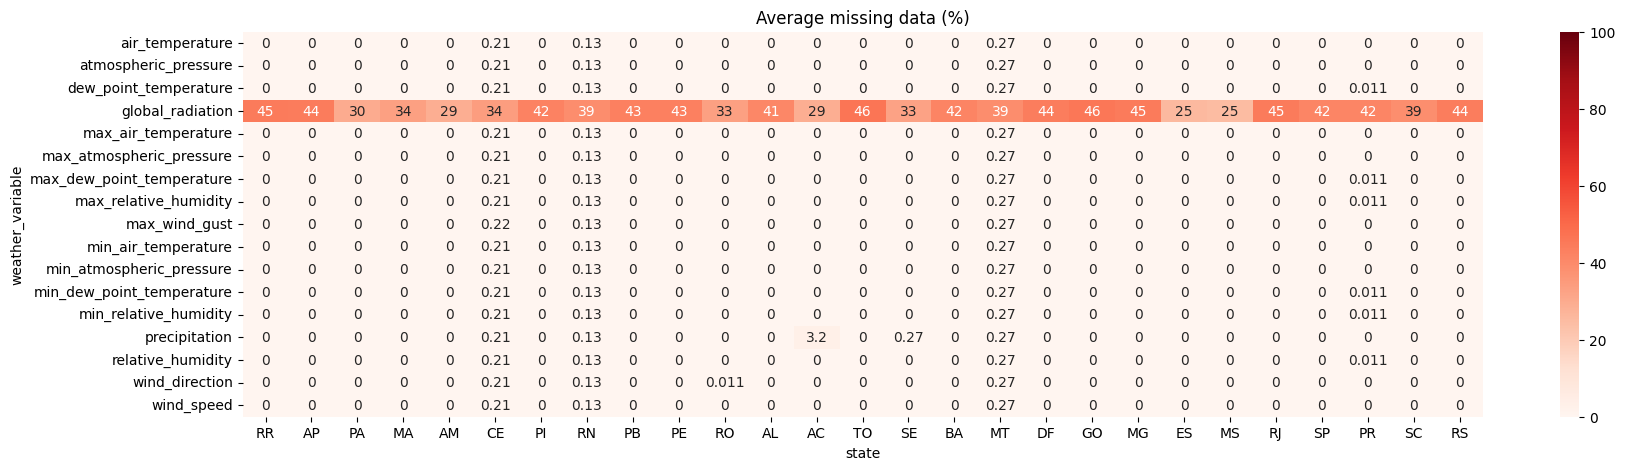

In [ ]:
# average missing data by state capital by variable
data = df.isna().sum()/df.shape[0]
data = data.reset_index()[['state', 'weather_variable', 0]]
data.columns = ['state', 'weather_variable', 'missing']
data = data.groupby(by=['state', 'weather_variable']).mean().reset_index()
data = data.pivot(index='weather_variable', columns='state', values='missing')
data = data*100
data = data[list(reversed(capital_dict.keys()))]
plt.figure(figsize=(20,5))
plt.title(f'Average missing data (%)')
sns.heatmap(data, vmin=0, vmax=100, cmap='Reds', annot=True)
plt.show()

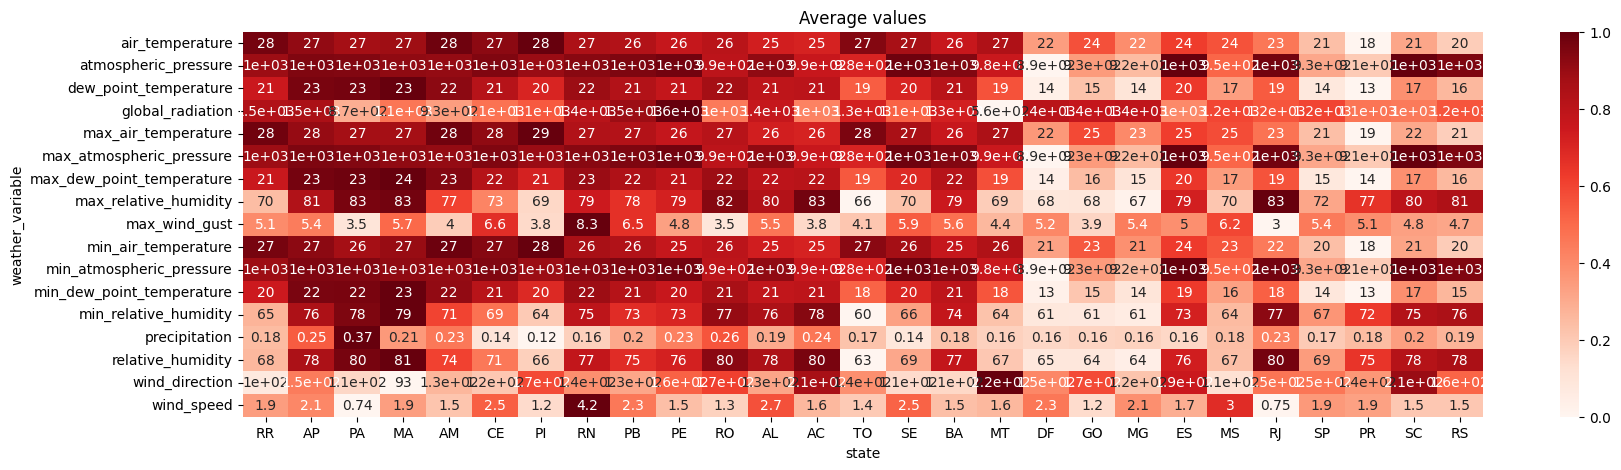

In [ ]:
# average values by year by climate variable
data = df.mean(axis=0).reset_index()
data.columns = ['state', 'weather_variable', 'value']
data = data[['state', 'weather_variable', 'value']]
data = data.groupby(by=['state', 'weather_variable']).mean().reset_index()
data = data.pivot(index='weather_variable', columns='state', values='value')
data = data[list(reversed(capital_dict.keys()))]
data_normalized = data.apply(lambda x: (x - x.min())/(x.max()-x.min()), axis=1)
data_normalized = data_normalized[list(reversed(capital_dict.keys()))]
plt.figure(figsize=(20,5))
plt.title('Average values')
sns.heatmap(data_normalized, cmap='Reds', annot=data)
plt.show()

In [ ]:
data.loc['global_radiation',:].sort_values(ascending=False)

state
PE    1636.427045
PB    1519.386552
AP    1477.931146
RR    1459.939693
RN    1432.838069
DF    1427.293809
MG    1409.908468
GO    1389.398832
AL    1388.198986
BA    1340.295178
TO    1335.628422
SP    1205.742813
MS    1202.449511
RS    1162.748373
RJ    1162.039069
PI    1149.155017
SE    1123.023821
CE    1072.926530
PR    1065.114813
MA    1060.029742
SC    1049.599530
RO    1047.554474
AC    1019.998972
ES     997.721962
AM     931.301995
PA     873.955023
MT     563.877463
Name: global_radiation, dtype: float64

#### Dealing with missing data

In general, we are able to deal well with missing data, the only exception being the variable global radiation. It has a high ammount of missing data (around 40%), and the pattern we see is different from the expected pattern (https://solarfy.com.br/blog/potencial-solar-no-brasil-confira-aqui-o-mapa-solarimetrico/ & https://www.solarvoltenergia.com.br/blog/mapa-de-insolacao/). Even after imputation, the pattern is not clear and varies a lot. But the other variables are more similar to the expected and consistent with the climate of the cities.

In [ ]:
df = pd.read_csv(f'{path}inmet/inmet_data_aggregated.csv', index_col=[0,1], header=[0,1])

In [ ]:
df.isna().sum().sum()

92562

<Axes: >

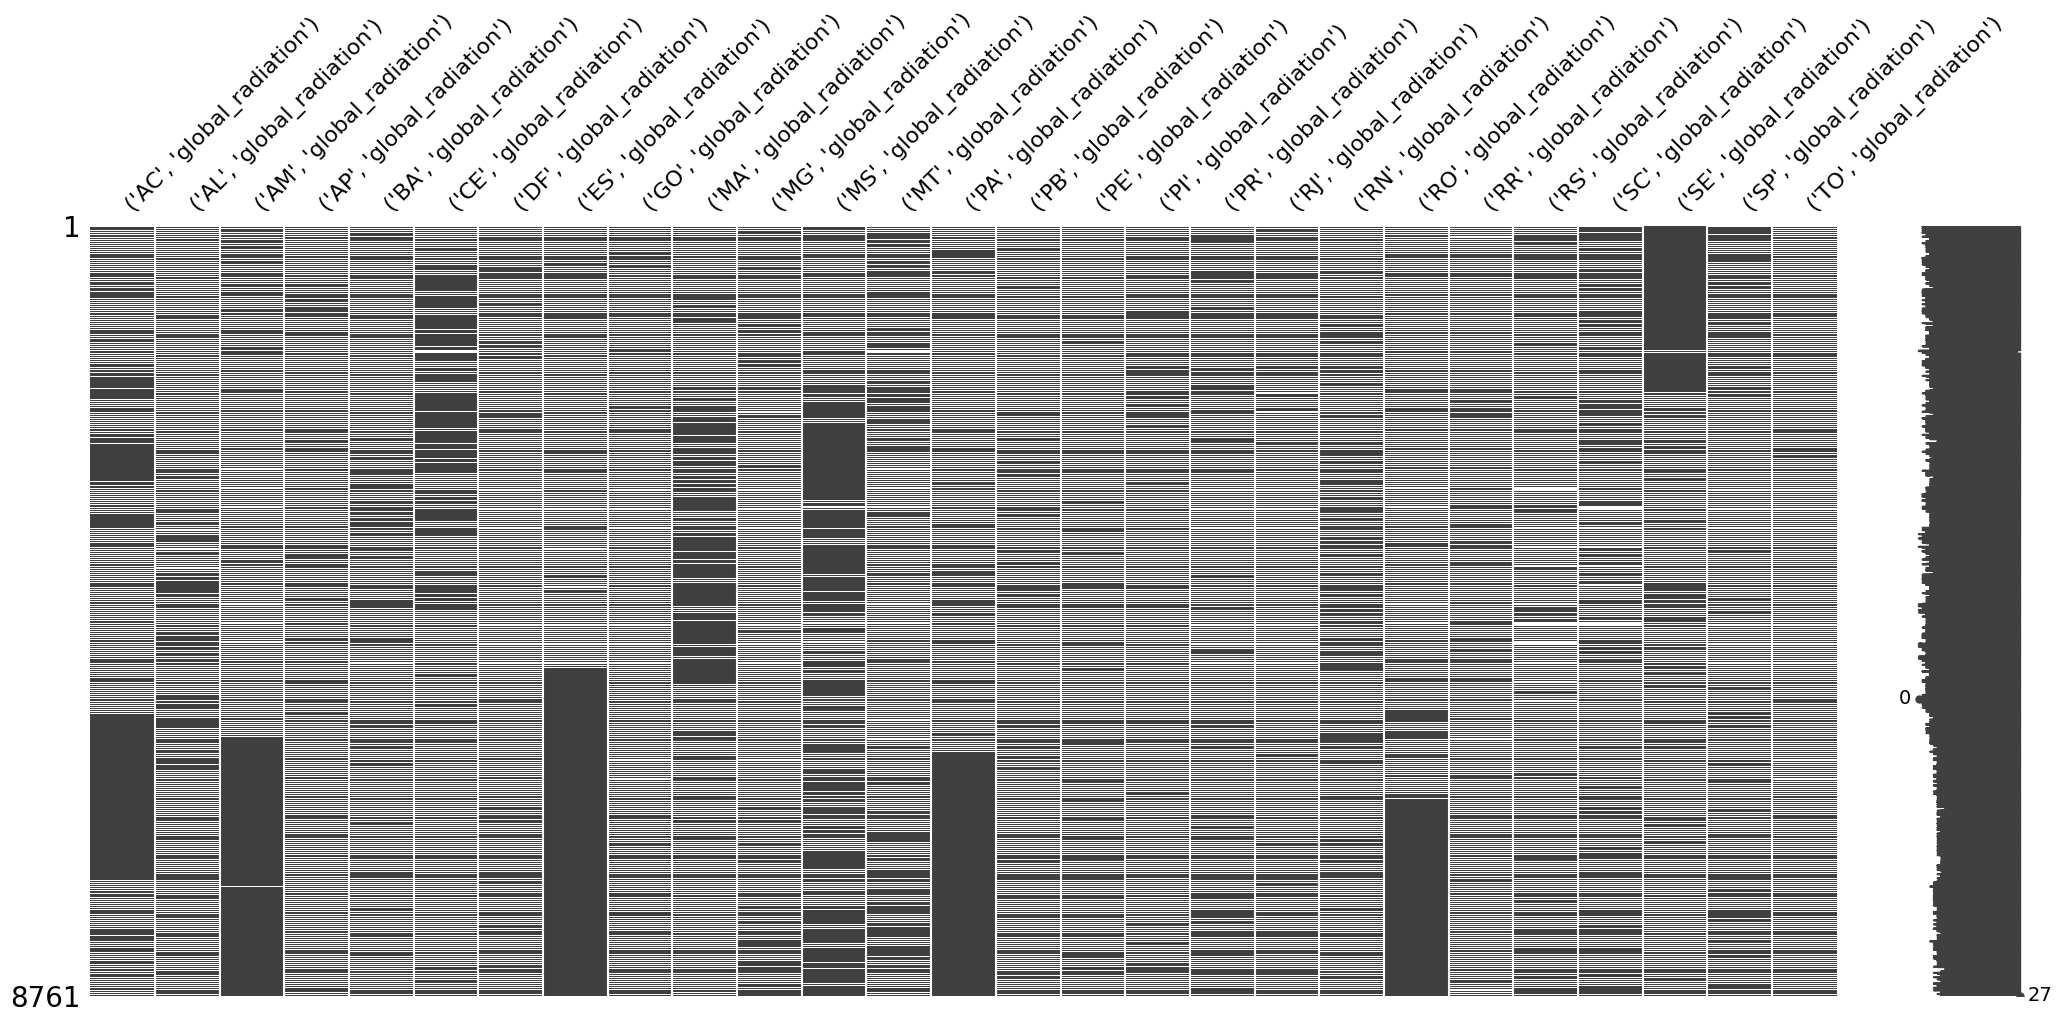

In [ ]:
global_radiation = df.loc[:,df.columns.get_level_values(1)=='global_radiation']
# display(global_radiation.isna().sum()/global_radiation.shape[0])
msno.matrix(global_radiation)

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_imputed = imputer.fit_transform(df)
df[:] = df_imputed
df.to_csv(f'{path}inmet/inmet_data_aggregated_imputed.csv', index=True)

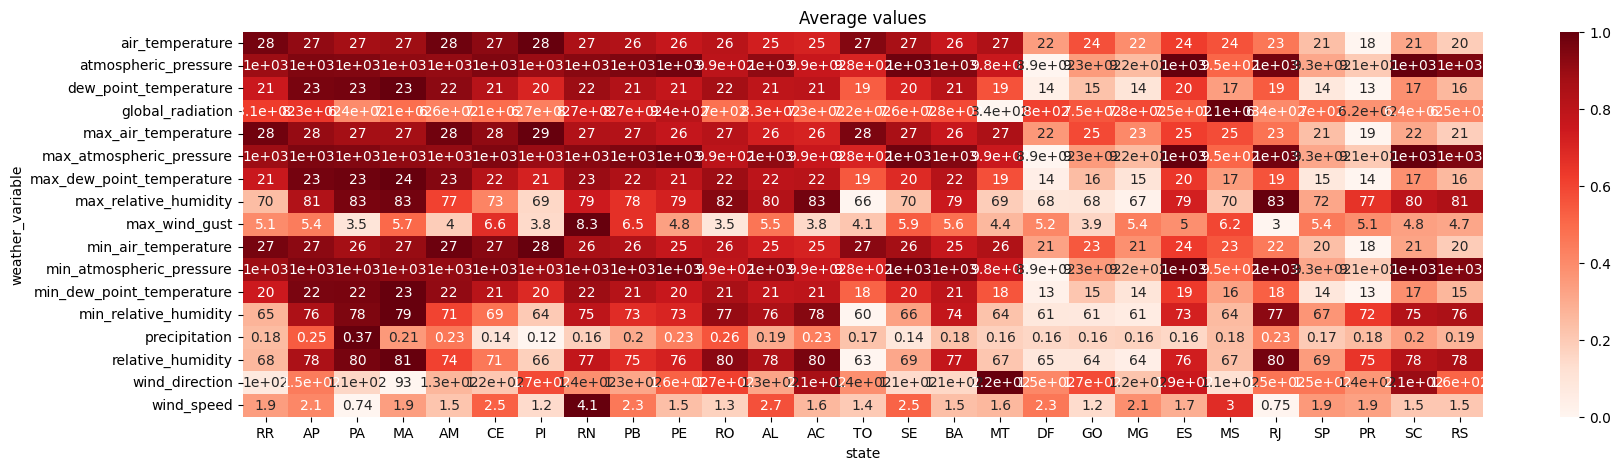

In [ ]:
# average values by year by climate variable
data = df.mean(axis=0).reset_index()
data.columns = ['state', 'weather_variable', 'value']
data = data[['state', 'weather_variable', 'value']]
data = data.groupby(by=['state', 'weather_variable']).mean().reset_index()
data = data.pivot(index='weather_variable', columns='state', values='value')
data = data[list(reversed(capital_dict.keys()))]
data_normalized = data.apply(lambda x: (x - x.min())/(x.max()-x.min()), axis=1)
data_normalized = data_normalized[list(reversed(capital_dict.keys()))]
plt.figure(figsize=(20,5))
plt.title('Average values')
sns.heatmap(data_normalized, cmap='Reds', annot=data)
plt.show()

In [ ]:
data.loc['global_radiation',:].sort_values(ascending=False)

state
MS    1088.941633
PE     944.560648
RN     873.799755
PB     873.384093
AL     831.724097
AP     826.476986
RR     809.210617
DF     799.375979
MG     782.981166
BA     781.195593
SE     756.682925
GO     754.428314
ES     745.764938
AC     729.353402
TO     717.876839
CE     707.558710
MA     705.569148
SP     703.723793
RO     698.909089
PI     667.425682
AM     660.944549
RS     651.549811
RJ     642.873004
SC     640.925627
PA     639.025050
PR     623.915177
MT     343.050923
Name: global_radiation, dtype: float64

### Non-aggregated data

#### Checking data

In [ ]:
df = pd.read_csv(f'{path}inmet/inmet_data.csv', index_col=[0,1], header=[0,1,2])

In [ ]:
df.columns

MultiIndex([('RS', '2000',      'atmospheric_pressure'),
            ('RS', '2000',  'max_atmospheric_pressure'),
            ('RS', '2000',  'min_atmospheric_pressure'),
            ('RS', '2000',          'global_radiation'),
            ('RS', '2000',           'air_temperature'),
            ('RS', '2000',     'dew_point_temperature'),
            ('RS', '2000',       'max_air_temperature'),
            ('RS', '2000',       'min_air_temperature'),
            ('RS', '2000', 'max_dew_point_temperature'),
            ('RS', '2000', 'min_dew_point_temperature'),
            ...
            ('RR', '2019',       'max_air_temperature'),
            ('RR', '2019',       'min_air_temperature'),
            ('RR', '2019', 'max_dew_point_temperature'),
            ('RR', '2019', 'min_dew_point_temperature'),
            ('RR', '2019',     'max_relative_humidity'),
            ('RR', '2019',     'min_relative_humidity'),
            ('RR', '2019',         'relative_humidity'),
            ('R

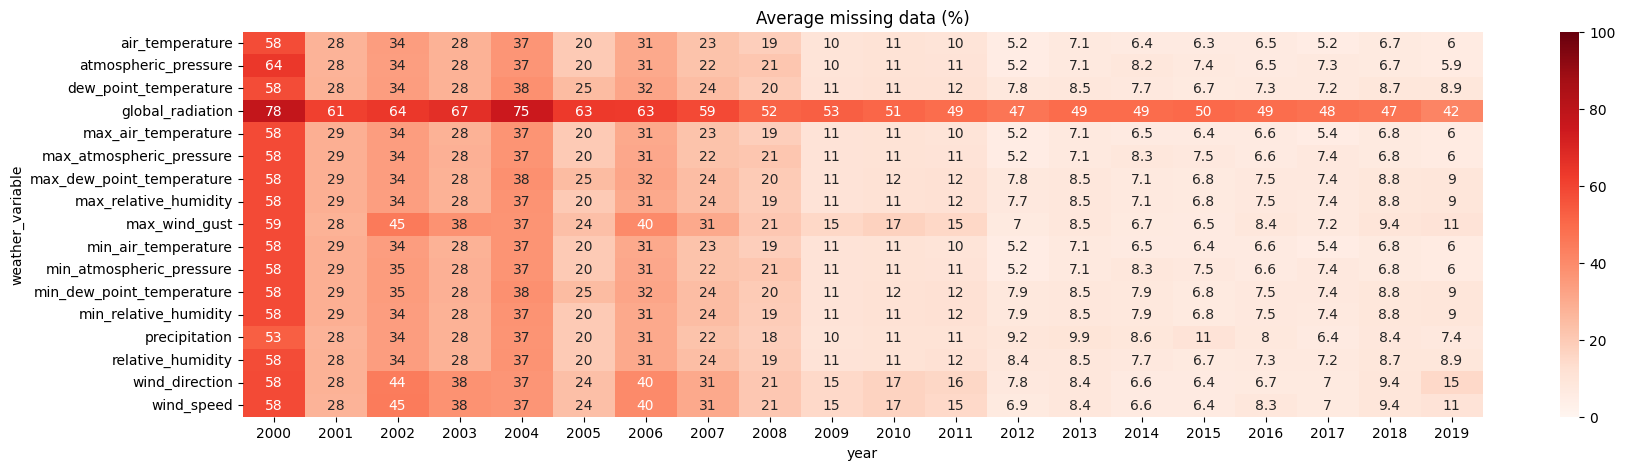

In [ ]:
# average missing data by year by variable
data = df.isna().sum()/df.shape[0]
data = data.reset_index()[['year', 'weather_variable', 0]]
data.columns = ['year', 'weather_variable', 'missing']
data = data.groupby(by=['year', 'weather_variable']).mean().reset_index()
data = data.pivot(index='weather_variable', columns='year', values='missing')
data = data*100
plt.figure(figsize=(20,5))
plt.title(f'Average missing data (%)')
sns.heatmap(data, vmin=0, vmax=100, cmap='Reds', annot=True)
plt.show()

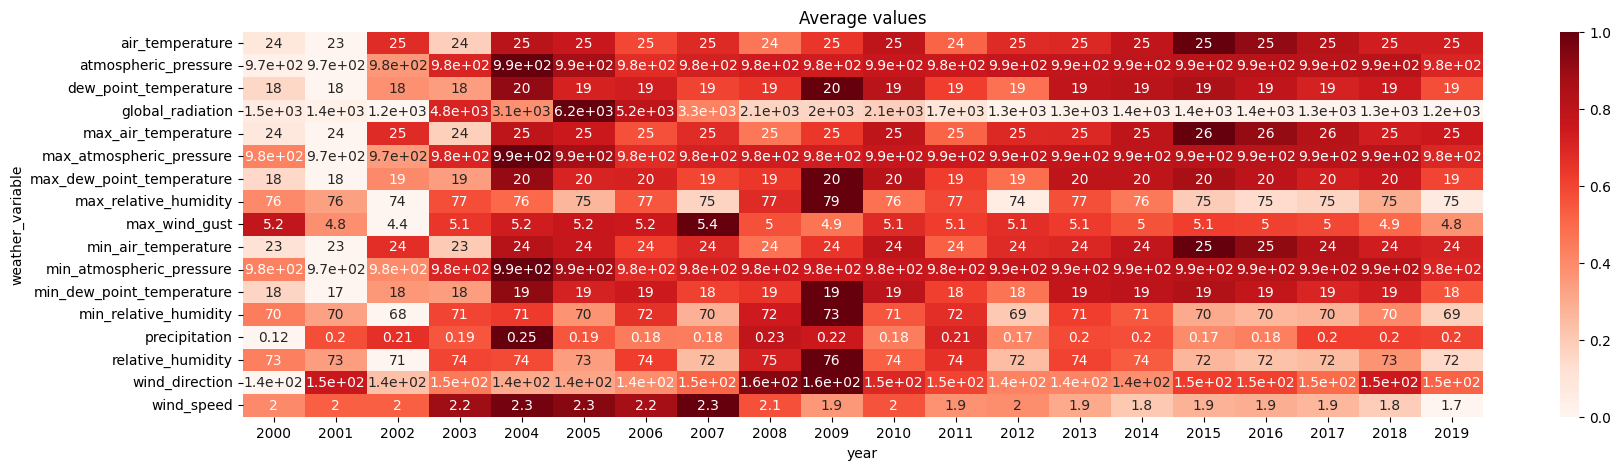

In [ ]:
# average values by year by climate variable
data = df.mean(axis=0).reset_index()
data.columns = ['state', 'year', 'weather_variable', 'value']
data = data[['year', 'weather_variable', 'value']]
data = data.groupby(by=['year', 'weather_variable']).mean().reset_index()
data = data.pivot(index='weather_variable', columns='year', values='value')
data_normalized = data.apply(lambda x: (x - x.min())/(x.max()-x.min()), axis=1)
plt.figure(figsize=(20,5))
plt.title('Average values')
sns.heatmap(data_normalized, cmap='Reds', annot=data)
plt.show()

In [ ]:
# #missing data by state by year by cause
# data = df.isna().sum()/df.shape[0]
# for state in list(station_dict.keys()):
#   data_state = data[data.index.get_level_values(0)==state].reset_index()
#   data_state = data_state[['year', 'weather_variable', 0]]
#   data_state.columns = ['year', 'weather_variable', 'missing']
#   data_state = data_state.pivot(index='weather_variable', columns='year', values='missing')
#   data_state = data_state*100
#   #add years not present as null values
#   interval = np.arange(2000, 2019+1).astype(str)
#   for year in interval:
#     if not year in data_state.columns:
#       data_state[year] = np.nan
#   data_state = data_state[interval]
#   plt.figure(figsize=(20,5))
#   plt.title(f'{capital_dict[state]}: missing data (%)')
#   sns.heatmap(data_state, vmin=0, vmax=100, cmap='Reds', annot=True)
#   plt.show()

In [ ]:
# # average values by state year by climate variable
# data = df.mean(axis=0).reset_index()
# data.columns = ['state', 'year', 'weather_variable', 'value']
# for state in list(station_dict.keys()):
#   data_state = data[data.state==state]
#   data_state = data_state[['year', 'weather_variable', 'value']]
#   data_state = data_state.groupby(by=['year', 'weather_variable']).mean().reset_index()
#   data_state = data_state.pivot(index='weather_variable', columns='year', values='value')
#   data_state_normalized = data_state.apply(lambda x: (x - x.min())/(x.max()-x.min()), axis=1)
#   #add years not present as null values
#   interval = np.arange(2000, 2019+1).astype(str)
#   for year in interval:
#     if not year in data_state.columns:
#       data_state[year] = np.nan
#       data_state_normalized[year] = np.nan
#   data_state = data_state[interval]
#   data_state_normalized = data_state_normalized[interval]
#   plt.figure(figsize=(20,5))
#   plt.title(f'{capital_dict[state]}: average values')
#   sns.heatmap(data_state_normalized, cmap='Reds', annot=data_state)
#   plt.show()

#### Dealing with missing data

In [ ]:
df = pd.read_csv(f'{path}inmet/inmet_data.csv', index_col=[0,1], header=[0,1,2])

In [ ]:
df.isna().sum().sum()

11129526

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_imputed = imputer.fit_transform(df)
df[:] = df_imputed
df.to_csv(f'{path}inmet/inmet_data_imputed.csv', index=True)